# Requirements

In [1]:
from datasets import load_dataset, Dataset
from transformers import AutoTokenizer, DataCollatorWithPadding
import pandas as pd

# Laboratory Exercise - Run Mode (8 points)

## Introduction
This laboratory assignment's primary objective is to fine-tune a pre-trained language model for binary classification on a dataset consisting of wine reviews. The dataset contains two attributes: **description** and **points**. The description is a brief text describing the wine and the points represent a quality metric ranging from 1 to 100. If some wine has at least 90 points it is considered **exceptional**. Your task involves predicting if some wine is **exceptional** based on its review.

## The Wine Reviews Dataset

Load the dataset using the `datasets` library.

In [38]:
df = pd.read_csv("wine-reviews.csv")
df

,description,points
0,"Translucent in color, silky in the mouth, this...",85
1,"On the palate, this wine is rich and complex, ...",92
2,The producer blends 57% Chardonnay from the Ma...,92
3,"Pure Baga in all its glory, packed with dry an...",93
4,Think of Subsídio as a contribution rather tha...,89
...,...,...
9995,"From the folks at Merryvale, this is a blend o...",92
9996,"An easy, versatile food wine or cocktail sippe...",84
9997,Black-fruit aromas blend nicely into chocolate...,93
9998,"This combines 61% Cabernet Sauvignon, 14% Syra...",90


In [40]:
dataset = load_dataset("csv", data_files="wine-reviews.csv", delimiter=",", split='train[:500]')
# dataset['train'] = dataset["train"].select(range(500))
# dataset['train'] = Dataset.from_pandas(df)
print(dataset)

Dataset({
    features: ['description', 'points'],
    num_rows: 500
})


In [41]:
dataset = dataset.train_test_split(test_size=0.2)
dataset

DatasetDict({
    train: Dataset({
        features: ['description', 'points'],
        num_rows: 400
    })
    test: Dataset({
        features: ['description', 'points'],
        num_rows: 100
    })
})

In [28]:
#1. (Much harder)
dataset['train'] = dataset['train'].map(lambda x: {'description' : x['description'] , 'points': 1} if x['points'] > 90 
else {'description' : x['description'] , 'points': 0})

Map:   0%|          | 0/400 [00:00<?, ? examples/s]

In [42]:
#2. (Much easier)
train_df = dataset['train'].to_pandas()
train_df['points'] = train_df['points'].apply(lambda x: 1 if x > 90 else 0)
train_df

,description,points
0,Scratchy plum and cassis aromas are earthy and...,0
1,"This tremendous wine is 100% Pinot Grigio, of ...",1
2,"This blend of Cabernet Sauvignon, Syrah and Me...",0
3,"While this wine does not age in wood, it does ...",0
4,"A rich, earthy Syrah from a new Terre Rouge vi...",0
...,...,...
395,"Made entirely from Pinot Noir grapes, this is ...",1
396,As in 2003 this is a blend of Stillwater Creek...,0
397,"A first rate Zinfandel, as rich as they come, ...",1
398,Waxy apple and melon aromas are basic but fres...,0


In [43]:
dataset['train'] = Dataset.from_pandas(train_df)
dataset['train']

Dataset({
    features: ['description', 'points'],
    num_rows: 400
})

In [71]:
dataset = dataset.rename_column("description", "text")
dataset = dataset.rename_column("points", "label")

## Dataset Splitting
Partition the dataset into training and testing sets with an 80:20 ratio.


In [73]:
dataset = dataset["train"].train_test_split(test_size=0.2)
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 400
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 100
    })
})

## Tokenization
Tokenize the texts using the `AutoTokenizer` class.

In [75]:
from transformers import AutoTokenizer
checkpoint = "google-bert/bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
print(tokenizer.model_max_length)  

In [76]:
def tokenize(sample):
    return tokenizer(sample["text"], truncation=True)
tokenized_dataset = dataset.map(tokenize, batched=True)

Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

In [78]:
from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 400
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 100
    })
})

## Fine-tuning a Pre-trained Language Model for Classification
Fine-tune a pre-trained language model for classification on the given dataset.

Define the model using the `AutoModelForSequenceClassification` class.

In [79]:
from transformers import TrainingArguments
from transformers import AutoModelForSequenceClassification

training_args = TrainingArguments(
    output_dir="trainer",
    eval_strategy="epoch",
    per_device_train_batch_size=16,  # batch size for training
    per_device_eval_batch_size=16,  # batch size for evaluation
    metric_for_best_model="f1",
    num_train_epochs=2,
)

model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Define the traning parameters using the `TrainingArguments` class.

In [80]:
import evaluate
metric = evaluate.load("f1")

Define the training using the `Trainer` class.

In [82]:
import numpy as np
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels, average="weighted")

Fine-tune (train) the pre-trained lanugage model.

In [83]:
from transformers import Trainer

trainer = Trainer(
    model,
    training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    compute_metrics=compute_metrics,
    data_collator=data_collator,
)

Use the trained model to make predictions for the test set.

In [85]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [86]:
trainer.train()

Epoch,Training Loss,Validation Loss,F1
1,No log,0.566366,0.707083
2,No log,0.527889,0.704717


TrainOutput(global_step=50, training_loss=0.5811162567138672, metrics={'train_runtime': 462.8028, 'train_samples_per_second': 1.729, 'train_steps_per_second': 0.108, 'total_flos': 38027769720000.0, 'train_loss': 0.5811162567138672, 'epoch': 2.0})

Assess the performance of the model by using different metrics provided by the `scikit-learn` library.

In [87]:
predictions = trainer.predict(tokenized_dataset["test"])

              precision    recall  f1-score   support

           0       0.71      0.93      0.81        61
           1       0.80      0.41      0.54        39

    accuracy                           0.73       100
   macro avg       0.76      0.67      0.68       100
weighted avg       0.75      0.73      0.70       100



Text(0.5, 1.0, 'Confusion Matrix')

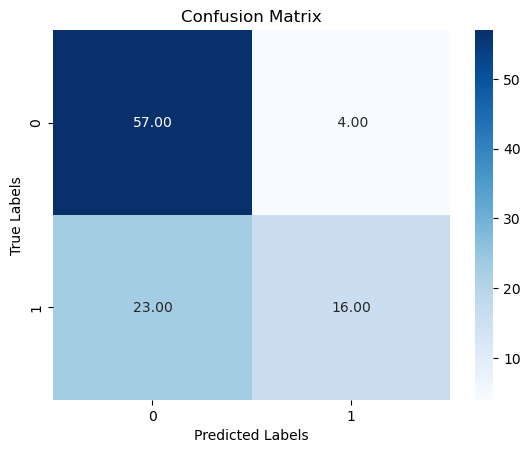

In [89]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

logits, labels = predictions.predictions, predictions.label_ids
preds = np.argmax(logits, axis=-1)

print(classification_report(labels, preds))

sns.heatmap(confusion_matrix(labels, preds), annot=True, fmt="5.2f", cmap="Blues")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")

# Laboratory Exercise - Bonus Task (+ 2 points)

Implement a simple machine learning pipeline to classify wine reviews as **exceptional** or not. Use TF-IDF vectorization to convert text into numerical features and train a logistic regression. Split the dataset into training and testing sets, fit the pipeline on the training data, and evaluate its performance using metrics such as precision, recall, and F1-score. Analyze the texts to find the most influential words or phrases associated with the **exceptional** wines. Use the coefficients from the logistic regression trained on TF-IDF features to identify the top positive and negative keywords for **exceptional** wines. Present these keywords in a simple table or visualization (e.g., bar chart).

In [ ]:
#TODO